_Lambda School Data Science, Unit 2_
 
# Regression 2 Sprint Challenge: Predict drugstore sales 🏥

For your Sprint Challenge, you'll use real-world sales data from a German drugstore chain, from Jan 2, 2013 — July 31, 2015.

You are given three dataframes:

- `train`: historical sales data for 100 stores
- `test`: historical sales data for 100 different stores
- `store`: supplemental information about the stores


The train and test set do _not_ have different date ranges. But they _do_ have different store ids. Your task is _not_ to forecast future sales from past sales. **Your task is to predict sales at unknown stores, from sales at known stores.**

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import eli5

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

from xgboost import XGBRegressor
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from eli5.sklearn import PermutationImportance

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [79]:
import pandas as pd
train = pd.read_csv('https://drive.google.com/uc?export=download&id=1E9rgiGf1f_WL2S4-V6gD7ZhB8r8Yb_lE')
test = pd.read_csv('https://drive.google.com/uc?export=download&id=1vkaVptn4TTYC9-YPZvbvmfDNHVR8aUml')
store = pd.read_csv('https://drive.google.com/uc?export=download&id=1rZD-V1mWydeytptQfr-NL7dBqre6lZMo')
assert train.shape == (78400, 7)
assert test.shape == (78400, 7)
assert store.shape == (200, 10)

The dataframes have a variety of columns:

- **Store** - a unique Id for each store
- **DayOfWeek** - integer, 1-6
- **Date** - the date, from Jan 2, 2013 — July 31, 2015.
- **Sales** - the units of inventory sold on a given date (this is the target you are predicting)
- **Customers** - the number of customers on a given date
- **Promo** - indicates whether a store is running a promo on that day
- **SchoolHoliday** - indicates the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

This Sprint Challenge has three parts. To demonstrate mastery on each part, do all the required instructions. To earn a score of "3" for the part, also do the stretch goals.

## 1. Wrangle relational data, Log-transform the target
- Merge the `store` dataframe with the `train` and `test` dataframes. 
- Arrange the X matrix and y vector for the train and test sets.
- Log-transform the target for the train and test set.
- Plot the target's distribution for the train set, before and after the transformation.

#### Stretch goals
- Engineer 3+ more features.

In [45]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
1,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
2,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
3,11,a,c,960.0,11.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
4,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [46]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday
0,4,5,2015-07-31,13995,1498,1,1
1,8,5,2015-07-31,8492,833,1,1
2,11,5,2015-07-31,10457,1236,1,1
3,12,5,2015-07-31,8959,962,1,1
4,34,5,2015-07-31,11144,1162,1,1


In [47]:
test.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday
0,10,5,2015-07-31,7185,681,1,1
1,15,5,2015-07-31,9191,766,1,1
2,31,5,2015-07-31,7248,645,1,1
3,47,5,2015-07-31,9379,1021,1,1
4,53,5,2015-07-31,7540,690,1,1


### Merge train, test and store

In [82]:
# Wrangle train, validation, and test sets
def wrangle(X):
    X = X.copy()
    
    # Engineer date features
    X['Date'] = pd.to_datetime(X['Date'], infer_datetime_format=True)
    X['date_year'] = X['Date'].dt.year
    X['date_month'] = X['Date'].dt.month
    X['date_day'] = X['Date'].dt.day
    X = X.drop(columns='Date')
    
    # Merge data
    X = (X.merge(store, how='left').fillna(0))
    
    return X

train = wrangle(train)
test = wrangle(test)

train.shape, test.shape

((78400, 18), (78400, 18))

### Arrange X matrix and y target for train and test

In [83]:
target = 'Sales'

X_train = train.drop(columns=target)
X_test = test.drop(columns=target)

y_train = train[target]
y_test = test[target]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((78400, 17), (78400, 17), (78400,), (78400,))

### log transform train and test target

In [84]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

### plot distribution of train target before and after transformation

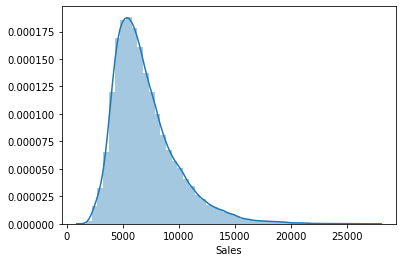

In [85]:
sns.distplot(y_train);

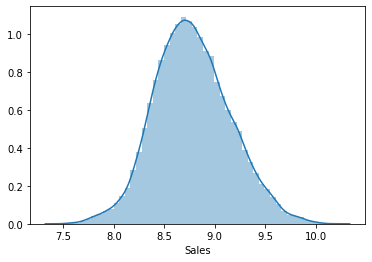

In [86]:
sns.distplot(y_train_log);

## 2. Fit and validate your model
- **Use Gradient Boosting** or any type of regression model.
- **Beat the baseline:** The estimated baseline Root Mean Squared Logarithmic Error is 0.90, if we guessed the mean sales for every prediction. Remember that RMSE with the log-transformed target is equivalent to RMSLE with the original target. Try to get your error below 0.20.
- **To validate your model, choose any one of these options:**
  - Split the train dataframe into train and validation sets. Put all dates for a given store into the same set. Use xgboost `early_stopping_rounds` with the validation set. 
  - Or, use scikit-learn `cross_val_score`. Put all dates for a given store into the same fold.
  - Or, use scikit-learn `RandomizedSearchCV` for hyperparameter optimization. Put all dates for a given store into the same fold.
- **Get the Validation Error** (multiple times if you try multiple iterations) **and Test Error** (one time, at the end).
  
#### Stretch goal
- Optimize 3+ hyperparameters by searching 10+ "candidates" (possible combinations of hyperparameters). 

In [87]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

### Build baseline model 

In [88]:
y_base = np.full_like(y_test_log, fill_value=y_train_log.mean())

print('Validation RMSLE, Mean Baseline:', rmse(y_test_log, y_base))

Validation RMSLE, Mean Baseline: 0.3948331905413732


### Split train data into train and validate, put all dates for a given store in the same set

In [94]:
stores = train['Store'].unique()

train_stores, val_stores = train_test_split(
    stores, random_state=42
)

train_stores = train[train.Store.isin(train_stores)]
val_stores = train[train.Store.isin(val_stores)]

assert train_stores.shape[0] + val_stores.shape[0] == train.shape[0]

In [97]:
target = 'Sales'

X_train = train_stores.drop(columns=target)
X_val = val_stores.drop(columns=target)

y_train = train_stores[target]
y_val = val_stores[target]

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

X_train.shape, X_val.shape

((58800, 17), (19600, 17))

### Use XGBoost to predict target

In [105]:
# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(
        n_estimators=1000, 
        n_jobs=-1,
        eval_metric='rmse',
        early_stopping_rounds=10
    )
)

# Fit
pipeline.fit(X_train, y_train_log)

# Validate
y_pred_log = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

[20:08:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation Error 0.1641765041445393


### Get the test error

In [106]:
y_pred_test = pipeline.predict(X_test)
print('Test Error', rmse(y_test_log, y_pred_test))

Test Error 0.15633498742026974


## 3. Plot model interpretation visualizations
- Choose any one of these options:
  - Permutation Importances plot
  - Partial Dependency Plot, 1 feature isolation
  - Partial Dependency Plot, 2 feature interaction
  
#### Stretch goals
- Plot 2+ visualizations.
- Use permutation importances for feature selection. 

In [120]:
X_val.columns

Index(['Store', 'DayOfWeek', 'Customers', 'Promo', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'date_year',
       'date_month', 'date_day'],
      dtype='object')

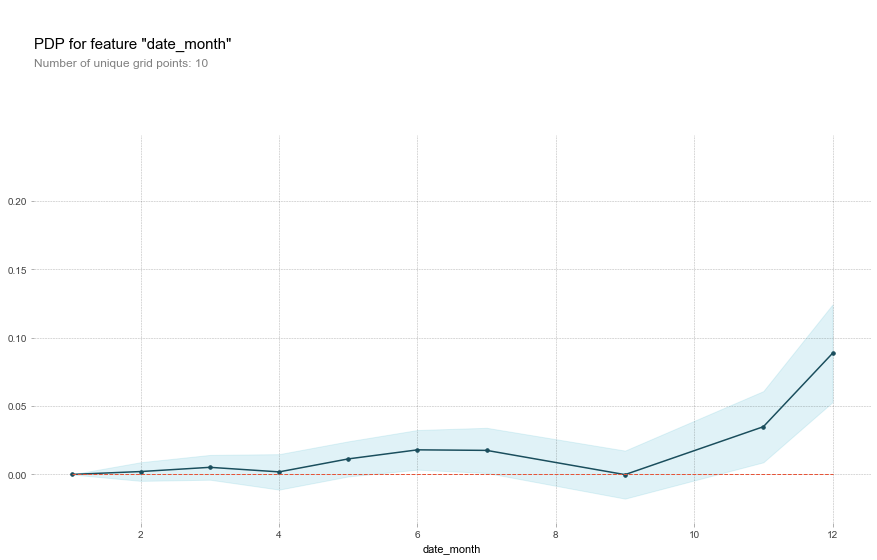

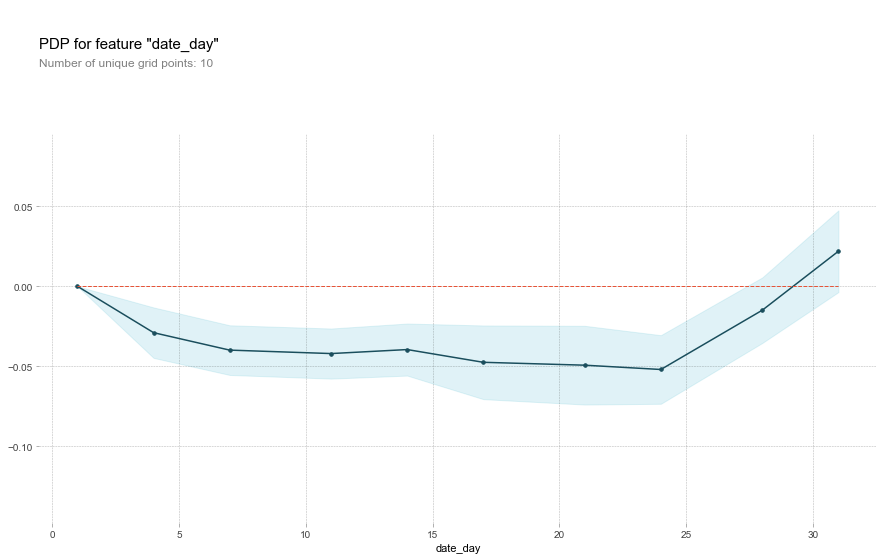

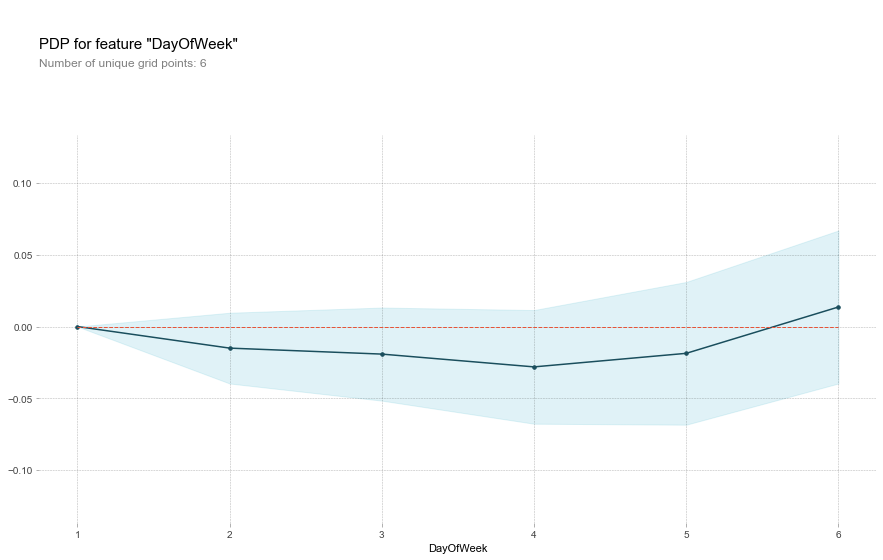

In [132]:
features = [
    'date_month',
    'date_day',
    'DayOfWeek'
]

for feature in features:
    isolated = pdp_isolate(
        model=pipeline, 
        dataset=X_val, 
        model_features=X_val.columns, 
        feature=feature
    )

    pdp_plot(isolated, feature_name=feature);